# 1. N-Gram Language Models

## Load dataset

In [40]:
def load_corpus(filepath: str):
    with open(filepath, "r") as f:
        lines = f.readlines()
    return [line.strip().lower().split() for line in lines]

dir_root = "/home/leo/LLM_HW1/"

training_corpus = load_corpus(dir_root + "train.txt")

## Build N-gram Language Model Class

In [41]:
import numpy as np
from collections import defaultdict
import random

class NGramLanguageModel:
    def __init__(self, n, smoothing=0.01):
        """
        Initialize N-gram language model
        Args:
            n: The value of n for n-grams (2 for bigram, 3 for trigram)
            smoothing: Smoothing parameter (Laplace/add-k smoothing)
        """
        self.n = n
        self.smoothing = smoothing
        self.n_gram_counts = None
        self.n_minus_1_gram_counts = None
        self.vocab = set()
    
    def n_gram_distribution(self, tokenized_corpus, n=2):

        if n < 2:
            raise ValueError("n must be larger than 1")

        n_minus_1_gram_counts = defaultdict(int)
        n_gram_counts = defaultdict(int)

        for sentence in tokenized_corpus:
            if len(sentence) < n:
                continue
            
            for i in range(len(sentence) - n + 1):
                n_gram = tuple(sentence[i : i + n])
                n_minus_1_gram = tuple(sentence[i : i + n - 1])
                
                n_minus_1_gram_counts[n_minus_1_gram] += 1
                n_gram_counts[n_gram] += 1
                
        return n_minus_1_gram_counts, n_gram_counts

    def train(self, tokenized_corpus):
        """Train the n-gram model on a tokenized corpus"""
        print(f"Training {self.n}-gram model...")
        
        # Get n-gram counts
        self.n_minus_1_gram_counts, self.n_gram_counts = self.n_gram_distribution(
            tokenized_corpus, self.n
        )
        
        # Build vocabulary
        for sentence in tokenized_corpus:
            self.vocab.update(sentence)
        
        # Build context index for fast lookup
        self.context_index = defaultdict(list)
        for n_gram in self.n_gram_counts.keys():
            context = n_gram[:-1]
            word = n_gram[-1]
            self.context_index[context].append(word)
        
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"{self.n-1}-gram types: {len(self.n_minus_1_gram_counts)}")
        print(f"{self.n}-gram types: {len(self.n_gram_counts)}")
        
    def get_probability(self, n_gram):
        """
        Calculate the probability of an n-gram with smoothing
        P(wn | w1...wn-1) = (count(w1...wn) + smoothing) / (count(w1...wn-1) + smoothing * V)
        """
        if len(n_gram) != self.n:
            raise ValueError(f"Expected {self.n}-gram, got {len(n_gram)}-gram")
        
        context = tuple(n_gram[:-1])  # n-1 gram (context)
        
        numerator = self.n_gram_counts.get(tuple(n_gram), 0) + self.smoothing
        denominator = self.n_minus_1_gram_counts.get(context, 0) + self.smoothing * len(self.vocab)
        
        return numerator / denominator
    
    def predict_next_word(self, context, top_k=5):
        """
        Predict the most likely next word given a context
        Args:
            context: tuple of n-1 words
            top_k: return top k predictions
        Returns:
            List of (word, probability) tuples
        """
        if len(context) != self.n - 1:
            raise ValueError(f"Context should have {self.n-1} words")
        
        context = tuple(context)
        candidates = []
        
        # Fast lookup using context index
        if context in self.context_index:
            for word in self.context_index[context]:
                n_gram = context + (word,)
                prob = self.get_probability(n_gram)
                candidates.append((word, prob))
        
        # Sort by probability
        candidates.sort(key=lambda x: x[1], reverse=True)
        
        return candidates[:top_k]
    
    def generate_sentence(self, start_words, max_length=20):
        """
        Generate a sentence starting with given words
        Args:
            start_words: List of starting words (should be n-1 words)
            max_length: Maximum length of generated sentence
            sampling: If True, sample from distribution; if False, take most likely
        Returns:
            Generated sentence as a list of words
        """
        if len(start_words) < self.n - 1:
            raise ValueError(f"Need at least {self.n-1} starting words")
        
        sentence = list(start_words)
        
        while len(sentence) < max_length:
            context = tuple(sentence[-(self.n-1):])
            candidates = self.predict_next_word(context, top_k=1)
            
            if not candidates:
                # No predictions available, stop
                break
            
            # Take the most likely word
            next_word = candidates[0][0]
            
            sentence.append(next_word)
        
        return sentence

## (a) Train Models and Evaluate on Test Set

### Load test dataset

In [3]:
test_corpus = load_corpus(dir_root + "test.txt")
print(f"Test corpus size: {len(test_corpus)} sentences")
print(f"First 3 test sentences: {test_corpus[:3]}")

Test corpus size: 649918 sentences
First 3 test sentences: [['test', 'for', 'doneness'], ['add', 'cabbage', 'and', 'carrots'], ['add', 'onion', 'and', 'cook', 'until', 'golden', 'brown']]


### Train Trigram Model (n=3)

In [42]:
import time

print("\n" + "=" * 60)
print("TRIGRAM MODEL (n=3)")
print("=" * 60)

trigram_model = NGramLanguageModel(n=3, smoothing=0.01)

start_time = time.time()
trigram_model.train(training_corpus)
train_time = time.time() - start_time

print(f"\nTraining time: {train_time:.2f} seconds")


TRIGRAM MODEL (n=3)
Training 3-gram model...
Vocabulary size: 63069
2-gram types: 622841
3-gram types: 2353735

Training time: 31.33 seconds
Vocabulary size: 63069
2-gram types: 622841
3-gram types: 2353735

Training time: 31.33 seconds


### Evaluate Models on Test Set

In [ ]:
def calculate_test_accuracy(model, test_corpus):
    """
    Calculate prediction accuracy on test set
    For each n-gram in test sentences, predict the next word and check if it matches
    """
    correct_predictions = 0
    total_predictions = 0
    
    print(f"Processing {len(test_corpus)} sentences...")
    
    for sent_idx, sentence in enumerate(test_corpus):
        if len(sentence) < model.n:
            continue
        
        if (sent_idx + 1) % 10000 == 0:
            print(f"  Processed {sent_idx + 1}/{len(test_corpus)} sentences... "
                  f"Current accuracy: {correct_predictions}/{total_predictions} "
                  f"({100*correct_predictions/total_predictions if total_predictions > 0 else 0:.2f}%)")
        
        for i in range(len(sentence) - model.n + 1):
            # Get context and actual next word
            context = tuple(sentence[i : i + model.n - 1])
            actual_word = sentence[i + model.n - 1]
            
            # Predict next word
            candidates = model.predict_next_word(context, top_k=1)
            
            if candidates:
                predicted_word = candidates[0][0]
                if predicted_word == actual_word:
                    correct_predictions += 1
            
            total_predictions += 1
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy, correct_predictions, total_predictions

In [9]:
# Evaluate Trigram Model
print("\n" + "=" * 60)
print("EVALUATING TRIGRAM MODEL ON TEST SET")
print("=" * 60)

trigram_accuracy, trigram_correct, trigram_total = calculate_test_accuracy(trigram_model, test_corpus)
print(f"\nTrigram Model Results:")
print(f"  Correct Predictions: {trigram_correct} / {trigram_total}")
print(f"  Accuracy: {trigram_accuracy * 100:.2f}%")


EVALUATING TRIGRAM MODEL ON TEST SET
Processing 649918 sentences...
  Processed 20000/649918 sentences... Current accuracy: 34275/95386 (35.93%)
  Processed 30000/649918 sentences... Current accuracy: 51234/142451 (35.97%)
  Processed 40000/649918 sentences... Current accuracy: 68277/190249 (35.89%)
  Processed 60000/649918 sentences... Current accuracy: 102420/286059 (35.80%)
  Processed 70000/649918 sentences... Current accuracy: 119552/334190 (35.77%)
  Processed 80000/649918 sentences... Current accuracy: 136416/381992 (35.71%)
  Processed 90000/649918 sentences... Current accuracy: 153337/429745 (35.68%)
  Processed 100000/649918 sentences... Current accuracy: 170482/477722 (35.69%)
  Processed 110000/649918 sentences... Current accuracy: 187455/525291 (35.69%)
  Processed 120000/649918 sentences... Current accuracy: 204461/572788 (35.70%)
  Processed 130000/649918 sentences... Current accuracy: 221300/619988 (35.69%)
  Processed 140000/649918 sentences... Current accuracy: 23866

## (b) Hardware Usage Monitoring

在training的時候發現memory佔比會比較高，並且都是用一個cpu跑的，但gpu卻是不會用到的，因為我們沒有用pytorch之類的gpu加速套件。
但是速度還是非常快的。
反之，testing的時候memory佔比高且時間非常的長。

## (c) Sentence Completion with Trigram Model

In [43]:
# Load incomplete sentences
incomplete_sentences = load_corpus(dir_root + "incomplete.txt")

print(f"Number of incomplete sentences: {len(incomplete_sentences)}")

Number of incomplete sentences: 10


In [44]:
# Complete sentences using the trigram model
print(f"\n{'='*80}")
print("SENTENCE COMPLETION USING TRIGRAM MODEL")
print(f"{'='*80}\n")

completed_sentences = []

for i, incomplete in enumerate(incomplete_sentences):
    print(f"Sentence {i}:")
    print(f"  Incomplete: {' '.join(incomplete)}")
    
    # Generate completion
    completed = trigram_model.generate_sentence(incomplete, max_length=20)
    completed_sentences.append(completed)
    
    print(f"  Completed:  {' '.join(completed)}")
    print(f"  Length: {len(completed)} words\n")


SENTENCE COMPLETION USING TRIGRAM MODEL

Sentence 0:
  Incomplete: cover with
  Completed:  cover with foil and bake for about 5 minutes or until the mixture into the pan and bake for about
  Length: 20 words

Sentence 1:
  Incomplete: roll up
  Completed:  roll up and place in a large bowl and mix well and set aside to cool completely on wire rack
  Length: 20 words

Sentence 2:
  Incomplete: cook the
  Completed:  cook the pasta and cook for about 5 minutes or until the mixture into the pan and bake for about
  Length: 20 words

Sentence 3:
  Incomplete: stir in
  Completed:  stir in the center of the pan and bake for about 5 minutes or until the mixture into the pan
  Length: 20 words

Sentence 4:
  Incomplete: spread out
  Completed:  spread out on a baking sheet and bake for about 5 minutes or until the mixture into the pan and
  Length: 20 words

Sentence 5:
  Incomplete: transfer the
  Completed:  transfer the mixture into the pan and bake for about 5 minutes or until the mixtu

# 2. RNN Model

## Prepare Data for RNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np

# Build vocabulary from training corpus
def build_vocab(corpus, min_freq=2):
    """Build vocabulary from corpus"""
    word_freq = defaultdict(int)
    for sentence in corpus:
        for word in sentence:
            word_freq[word] += 1
    
    # Add special tokens
    vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2}
    idx = 3
    
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

# Build vocabulary
rnn_vocab = build_vocab(training_corpus, min_freq=2)
vocab_size = len(rnn_vocab)
print(f"RNN Vocabulary size: {vocab_size}")

RNN Vocabulary size: 28127


In [4]:
# Create Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, corpus, vocab, seq_length=20):
        self.vocab = vocab
        self.seq_length = seq_length
        self.data = []
        
        # Convert corpus to sequences
        for sentence in corpus:
            # Convert words to indices
            indices = [vocab.get(word, vocab['<unk>']) for word in sentence]
            indices.append(vocab['<eos>'])  # Add end of sentence token
            
            # Create sequences of fixed length
            for i in range(len(indices) - 1):
                if i + seq_length + 1 <= len(indices):
                    # Input: seq_length words, Target: next seq_length words
                    input_seq = indices[i:i+seq_length]
                    target_seq = indices[i+1:i+seq_length+1]
                    self.data.append((input_seq, target_seq))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

# Create datasets
seq_length = 20
train_dataset = LanguageModelDataset(training_corpus, rnn_vocab, seq_length=seq_length)
test_dataset = LanguageModelDataset(test_corpus, rnn_vocab, seq_length=seq_length)

print(f"Training sequences: {len(train_dataset)}")
print(f"Test sequences: {len(test_dataset)}")

Training sequences: 180758
Test sequences: 44150


In [5]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 5649
Number of test batches: 1380


## Build RNN Language Model

In [27]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=2, dropout=0.5):
        super(RNNLanguageModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # RNN layer
        self.rnn = nn.RNN(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # RNN forward pass
        output, hidden = self.rnn(embedded, hidden)  # output: (batch_size, seq_length, hidden_dim)
        
        # Apply dropout and linear layer
        output = self.dropout(output)
        output = self.fc(output)  # (batch_size, seq_length, vocab_size)
        
        return output, hidden

# Create RNN model
rnn_model = RNNLanguageModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=128,
    num_layers=2,
    dropout=0.2
)

print(rnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")

RNNLanguageModel(
  (embedding): Embedding(28127, 128)
  (rnn): RNN(128, 128, num_layers=2)
  (fc): Linear(in_features=128, out_features=28127, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 7,294,687


## Train RNN Model

In [29]:
def train_rnn(model, train_loader, criterion, optimizer, device):
    """Train the RNN model for one epoch"""
    model.train()
    total_loss = 0
    total_correct = 0
    total_words = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output, _ = model(inputs)
        
        # Reshape for loss calculation
        # output: (batch_size, seq_length, vocab_size)
        # targets: (batch_size, seq_length)
        output = output.reshape(-1, vocab_size)
        targets = targets.reshape(-1)
        
        # Calculate loss
        loss = criterion(output, targets)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == targets).sum().item()
        total_words += targets.size(0)
        total_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'  Batch {batch_idx+1}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100*total_correct/total_words:.2f}%')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_words
    
    return avg_loss, accuracy

def evaluate_rnn(model, test_loader, criterion, device):
    """Evaluate the RNN model"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_words = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            output, _ = model(inputs)
            
            # Reshape for loss calculation
            output = output.reshape(-1, vocab_size)
            targets = targets.reshape(-1)
            
            # Calculate loss
            loss = criterion(output, targets)
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            total_correct += (predicted == targets).sum().item()
            total_words += targets.size(0)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_words
    perplexity = np.exp(avg_loss)
    
    return avg_loss, accuracy, perplexity

# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

rnn_model = rnn_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

print("\nModel ready for training!")

Using device: cuda

Model ready for training!


In [30]:
# Train the model
num_epochs = 10

# Store training history
history = {
    'train_loss': [],
    'train_acc': [],
}

print("="*60)
print("TRAINING RNN LANGUAGE MODEL")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_rnn(rnn_model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)

TRAINING RNN LANGUAGE MODEL

Epoch 1/10
------------------------------------------------------------
  Batch 100/5649, Loss: 6.1783, Acc: 5.87%
  Batch 100/5649, Loss: 6.1783, Acc: 5.87%
  Batch 200/5649, Loss: 6.1769, Acc: 6.92%
  Batch 200/5649, Loss: 6.1769, Acc: 6.92%
  Batch 300/5649, Loss: 5.7661, Acc: 7.77%
  Batch 300/5649, Loss: 5.7661, Acc: 7.77%
  Batch 400/5649, Loss: 5.7882, Acc: 8.41%
  Batch 400/5649, Loss: 5.7882, Acc: 8.41%
  Batch 500/5649, Loss: 5.6704, Acc: 9.17%
  Batch 500/5649, Loss: 5.6704, Acc: 9.17%
  Batch 600/5649, Loss: 5.5194, Acc: 9.98%
  Batch 600/5649, Loss: 5.5194, Acc: 9.98%
  Batch 700/5649, Loss: 5.0138, Acc: 10.83%
  Batch 700/5649, Loss: 5.0138, Acc: 10.83%
  Batch 800/5649, Loss: 5.1558, Acc: 11.63%
  Batch 800/5649, Loss: 5.1558, Acc: 11.63%
  Batch 900/5649, Loss: 5.0693, Acc: 12.37%
  Batch 900/5649, Loss: 5.0693, Acc: 12.37%
  Batch 1000/5649, Loss: 4.9950, Acc: 13.00%
  Batch 1000/5649, Loss: 4.9950, Acc: 13.00%
  Batch 1100/5649, Loss: 4.98

## Plot Learning Curves

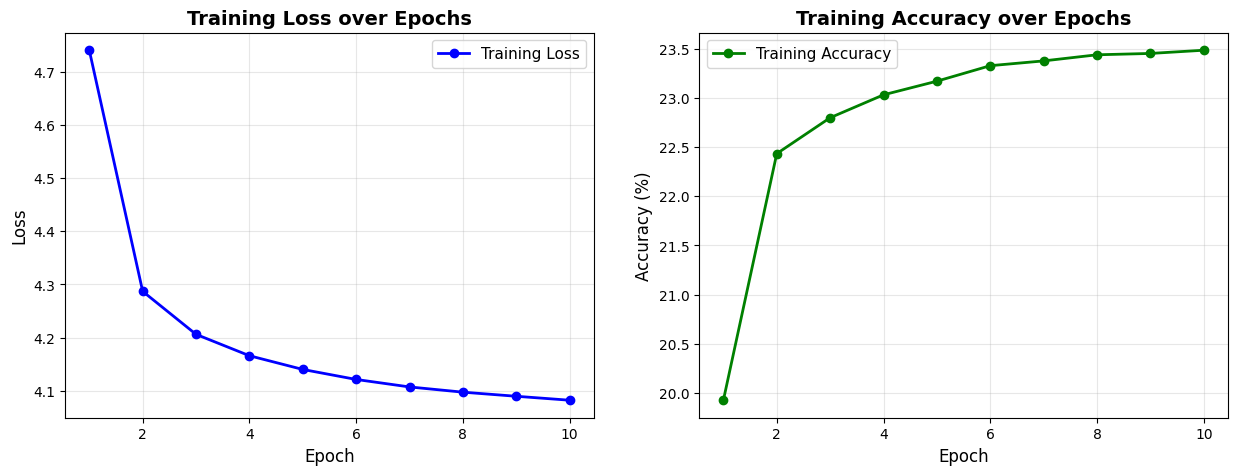

In [34]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, num_epochs + 1)

# Plot 1: Training Loss
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Training Accuracy
axes[1].plot(epochs, [acc * 100 for acc in history['train_acc']], 'g-o', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

## Evaluate the RNN model on test data

In [35]:
# Evaluate
test_loss, test_acc, test_perplexity = evaluate_rnn(rnn_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc*100:.2f}%, Perplexity: {test_perplexity:.2f}")

Test Accuracy: 23.00%, Perplexity: 86.50


## Text Generation with RNN

In [45]:
def generate_text_rnn(model, start_words, vocab, max_length=20, temperature=1.0, device='cpu'):
    """
    Generate text using the trained RNN model
    Args:
        model: Trained RNN model
        start_words: List of starting words
        vocab: Vocabulary dictionary
        max_length: Maximum length of generated sequence
        temperature: Sampling temperature (higher = more random)
        device: Device to run on
    Returns:
        Generated text as a list of words
    """
    model.eval()
    
    # Create reverse vocabulary
    idx_to_word = {idx: word for word, idx in vocab.items()}
    
    # Convert start words to indices
    current_seq = [vocab.get(word, vocab['<unk>']) for word in start_words]
    generated = list(start_words)
    
    with torch.no_grad():
        for _ in range(max_length - len(start_words)):
            # Prepare input
            input_tensor = torch.tensor([current_seq], dtype=torch.long).to(device)
            
            # Get model prediction
            output, _ = model(input_tensor)
            
            # Get last word prediction
            logits = output[0, -1, :] / temperature
            probs = torch.softmax(logits, dim=0)
            
            # Sample next word
            next_idx = torch.multinomial(probs, 1).item()
            next_word = idx_to_word.get(next_idx, '<unk>')
            
            # Stop if end of sentence
            if next_word == '<eos>':
                break
            
            generated.append(next_word)
            current_seq.append(next_idx)
            
            # Keep only last seq_length words for context
            if len(current_seq) > seq_length:
                current_seq = current_seq[-seq_length:]
    
    return generated

# Test text generation with incomplete sentences
print("="*80)
print("RNN TEXT GENERATION")
print("="*80)

for i, incomplete in enumerate(incomplete_sentences):
    print(f"\nSentence {i}:")
    print(f"  Incomplete: {' '.join(incomplete)}")
    
    # Generate completion
    completed = generate_text_rnn(rnn_model, incomplete, rnn_vocab, max_length=20, temperature=0.8, device=device)
    
    print(f"  Completed:  {' '.join(completed)}")
    print(f"  Length: {len(completed)} words")

RNN TEXT GENERATION

Sentence 0:
  Incomplete: cover with
  Completed:  cover with plastic wrap
  Length: 4 words

Sentence 1:
  Incomplete: roll up
  Completed:  roll up with the petals for the bottom of chicken is silky and transfer the nuts 1 / 2 inch
  Length: 20 words

Sentence 2:
  Incomplete: cook the
  Completed:  cover with plastic wrap
  Length: 4 words

Sentence 1:
  Incomplete: roll up
  Completed:  roll up with the petals for the bottom of chicken is silky and transfer the nuts 1 / 2 inch
  Length: 20 words

Sentence 2:
  Incomplete: cook the
  Completed:  cook the bottom of the top of the lower the icing over a wooden spoon to loosen the oven for
  Length: 20 words

Sentence 3:
  Incomplete: stir in
  Completed:  stir in the basil leaves the cheese and place on how much as i thicken and brown and place on
  Length: 20 words

Sentence 4:
  Incomplete: spread out
  Completed:  spread out as you want to blend together with the whipped cream for the mixture in the onion and p

# 3. LSTM Model

In [46]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=2, dropout=0.5):
        super(LSTMLanguageModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM forward pass
        output, hidden = self.lstm(embedded, hidden)  # output: (batch_size, seq_length, hidden_dim)
        
        # Apply dropout and linear layer
        output = self.dropout(output)
        output = self.fc(output)  # (batch_size, seq_length, vocab_size)
        
        return output, hidden

# Create LSTM model
lstm_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=128,
    num_layers=2,
    dropout=0.2
)

print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

LSTMLanguageModel(
  (embedding): Embedding(28127, 128)
  (lstm): LSTM(128, 128, num_layers=2)
  (fc): Linear(in_features=128, out_features=28127, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 7,492,831


## Train LSTM Model

In [47]:
def train_lstm(model, train_loader, criterion, optimizer, device):
    """Train the LSTM model for one epoch"""
    model.train()
    total_loss = 0
    total_correct = 0
    total_words = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output, _ = model(inputs)
        
        # Reshape for loss calculation
        # output: (batch_size, seq_length, vocab_size)
        # targets: (batch_size, seq_length)
        output = output.reshape(-1, vocab_size)
        targets = targets.reshape(-1)
        
        # Calculate loss
        loss = criterion(output, targets)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == targets).sum().item()
        total_words += targets.size(0)
        total_loss += loss.item() * targets.size(0)
        
        if (batch_idx + 1) % 100 == 0:
            print(f'  Batch {batch_idx+1}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100*total_correct/total_words:.2f}%')
    
    avg_loss = total_loss / total_words
    accuracy = total_correct / total_words
    
    return avg_loss, accuracy

def evaluate_lstm(model, test_loader, criterion, device):
    """Evaluate the LSTM model"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_words = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            output, _ = model(inputs)
            
            # Reshape for loss calculation
            output = output.reshape(-1, vocab_size)
            targets = targets.reshape(-1)
            
            # Calculate loss
            loss = criterion(output, targets)
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            total_correct += (predicted == targets).sum().item()
            total_words += targets.size(0)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_words
    perplexity = np.exp(avg_loss)
    
    return avg_loss, accuracy, perplexity

# Setup training
lstm_model = lstm_model.to(device)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

print(f"Using device: {device}")
print("\nModel ready for training!")

Using device: cuda

Model ready for training!


In [ ]:
# Train the LSTM model
num_epochs = 10

# Store training history
lstm_history = {
    'train_loss': [],
    'train_acc': [],
}

print("="*60)
print("TRAINING LSTM LANGUAGE MODEL")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_lstm(lstm_model, train_loader, criterion_lstm, optimizer_lstm, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
    
    # Store history
    lstm_history['train_loss'].append(train_loss)
    lstm_history['train_acc'].append(train_acc)

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)

TRAINING LSTM LANGUAGE MODEL

Epoch 1/10
------------------------------------------------------------
  Batch 100/5649, Loss: 6.1631, Acc: 5.59%
  Batch 100/5649, Loss: 6.1631, Acc: 5.59%
  Batch 200/5649, Loss: 6.4798, Acc: 6.01%
  Batch 200/5649, Loss: 6.4798, Acc: 6.01%
  Batch 300/5649, Loss: 6.1385, Acc: 6.17%
  Batch 300/5649, Loss: 6.1385, Acc: 6.17%
  Batch 400/5649, Loss: 6.3080, Acc: 6.22%
  Batch 400/5649, Loss: 6.3080, Acc: 6.22%
  Batch 500/5649, Loss: 6.1776, Acc: 6.31%
  Batch 500/5649, Loss: 6.1776, Acc: 6.31%
  Batch 600/5649, Loss: 6.0722, Acc: 6.36%
  Batch 600/5649, Loss: 6.0722, Acc: 6.36%
  Batch 700/5649, Loss: 6.1147, Acc: 6.40%
  Batch 700/5649, Loss: 6.1147, Acc: 6.40%
  Batch 800/5649, Loss: 6.2504, Acc: 6.45%
  Batch 800/5649, Loss: 6.2504, Acc: 6.45%
  Batch 900/5649, Loss: 6.2047, Acc: 6.50%
  Batch 900/5649, Loss: 6.2047, Acc: 6.50%
  Batch 1000/5649, Loss: 6.1447, Acc: 6.51%
  Batch 1000/5649, Loss: 6.1447, Acc: 6.51%
  Batch 1100/5649, Loss: 6.0762, Acc

## Plot LSTM Learning Curves

In [ ]:
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, num_epochs + 1)

# Plot 1: Training Loss
axes[0].plot(epochs_range, lstm_history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('LSTM Training Loss over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Training Accuracy
axes[1].plot(epochs_range, [acc * 100 for acc in lstm_history['train_acc']], 'g-o', label='Training Accuracy', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('LSTM Training Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)


## Evaluate the LSTM model on test data

In [ ]:
# Evaluate
test_loss_lstm, test_acc_lstm, test_perplexity_lstm = evaluate_lstm(rnn_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc_lstm*100:.2f}%, Perplexity: {test_perplexity_lstm:.2f}")

## Text Generation with LSTM

In [ ]:
def generate_text_lstm(model, start_words, vocab, max_length=20, temperature=1.0, device='cpu'):
    """
    Generate text using the trained LSTM model
    Args:
        model: Trained LSTM model
        start_words: List of starting words
        vocab: Vocabulary dictionary
        max_length: Maximum length of generated sequence
        temperature: Sampling temperature (higher = more random)
        device: Device to run on
    Returns:
        Generated text as a list of words
    """
    model.eval()
    
    # Create reverse vocabulary
    idx_to_word = {idx: word for word, idx in vocab.items()}
    
    # Convert start words to indices
    current_seq = [vocab.get(word, vocab['<unk>']) for word in start_words]
    generated = list(start_words)
    
    with torch.no_grad():
        for _ in range(max_length - len(start_words)):
            # Prepare input
            input_tensor = torch.tensor([current_seq], dtype=torch.long).to(device)
            
            # Get model prediction
            output, _ = model(input_tensor)
            
            # Get last word prediction
            logits = output[0, -1, :] / temperature
            probs = torch.softmax(logits, dim=0)
            
            # Sample next word
            next_idx = torch.multinomial(probs, 1).item()
            next_word = idx_to_word.get(next_idx, '<unk>')
            
            # Stop if end of sentence
            if next_word == '<eos>':
                break
            
            generated.append(next_word)
            current_seq.append(next_idx)
            
            # Keep only last seq_length words for context
            if len(current_seq) > seq_length:
                current_seq = current_seq[-seq_length:]
    
    return generated

# Test text generation with incomplete sentences
print("="*80)
print("LSTM TEXT GENERATION")
print("="*80)

for i, incomplete in enumerate(incomplete_sentences[:5], 1):
    print(f"\nSentence {i}:")
    print(f"  Incomplete: {' '.join(incomplete)}")
    
    # Generate completion
    completed = generate_text_lstm(lstm_model, incomplete, rnn_vocab, max_length=20, temperature=0.8, device=device)
    
    print(f"  Completed:  {' '.join(completed)}")
    print(f"  Length: {len(completed)} words")

## Model Comparison: N-gram vs RNN vs LSTM

In [ ]:
# Compare final performance of all three models
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

print("\n1. N-GRAM MODEL (Trigram):")
print(f"   Test Accuracy: {trigram_accuracy * 100:.2f}%")

print("\n2. RNN MODEL:")
if len(history['train_loss']) > 0:
    print(f"   Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"   Training Accuracy: {history['train_acc'][-1] * 100:.2f}%")
    print(f"   Test Accuracy: {test_acc * 100:.2f}%")
    print(f"   Test Perplexity: {test_perplexity:.2f}")
else:
    print("   Not trained yet")

print("\n3. LSTM MODEL:")
if len(lstm_history['train_loss']) > 0:
    print(f"   Training Loss: {lstm_history['train_loss'][-1]:.4f}")
    print(f"   Training Accuracy: {lstm_history['train_acc'][-1] * 100:.2f}%")
    print(f"   Test Accuracy: {test_acc_lstm * 100:.2f}%")
    print(f"   Test Perplexity: {test_perplexity_lstm:.2f}")
else:
    print("   Not trained yet")

print("\n" + "="*80)